## 注意力分数

<img src='../images/65image1.png' width='600'>

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import math

- mask softmax操作

In [3]:
def masked_softmax(X, valid_lens):
    # X 3D, valid 1D or 2D
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return F.softmax(X.reshape((shape)), dim=-1)

- 考虑由两个 2 x 4的样本， 这两个样本的有效长度分别为2和3

In [4]:
X = torch.rand((2, 2, 4))
valid_lens = torch.tensor([2, 3])
# # torch.repeat_interleave(valid_lens, X.shape[1])
masked_softmax(X, valid_lens)

tensor([[[0.5426, 0.4574, 0.0000, 0.0000],
         [0.4468, 0.5532, 0.0000, 0.0000]],

        [[0.3188, 0.3906, 0.2906, 0.0000],
         [0.3739, 0.3449, 0.2812, 0.0000]]])

- 如果valid_lens 是二维张量，那么指定的是每个样本的有效长度

In [5]:
masked_softmax(X, torch.tensor([[1, 2], [3, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4468, 0.5532, 0.0000, 0.0000]],

        [[0.3188, 0.3906, 0.2906, 0.0000],
         [0.3739, 0.3449, 0.2812, 0.0000]]])

### 加性注意力
- 当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。给定查询$\mathbf{q} \in \mathbb{R}^q$和键$\mathbf{k} \in \mathbb{R}^k$， 加性注意力（additive attention）的评分函数为:
  $$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
- 其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、$\mathbf W_k\in\mathbb R^{h\times k}$和$\mathbf w_v\in\mathbb R^{h}$

In [6]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens,bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        """
        queries [bs, n_q, d_q]
        keys [bs, n_k, d_k]
        values [bs, n_k, d_v]
        valid_len [bs, ] or [bs, n_q]对于每个query，我要考虑前多少个kv-pair
        """
        queries, keys = self.W_q(queries), self.W_k(keys)
        # [bs, n_q, h] [bs, n_k, h]
        # q和每个k都要做查询，所以k复制q份，q的每个元素复制k份
        # [bs, n_q, n_k, h] [bs, n_q, 1, h] [bs, 1, n_k, h]
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # [bs, n_q, n_k] 每个batch中每个query对于每个k的注意力分数
        scores = self.w_v(features).squeeze(-1)
        # [bs, n_q, n_k] 每个batch中每个query对于每个k的注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [7]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones(2, 10, 2)
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)

valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens), attention.attention_weights.shape, attention(queries, keys, values, valid_lens).shape

(tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],
 
         [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>),
 torch.Size([2, 1, 10]),
 torch.Size([2, 1, 4]))

- 在此例子中，健key都是相同的，所以注意力权重是均匀的，由指定的有效长度决定
- 下面的例子中，attention_weights是一个[bs, n_q, n_k]的矩阵，表示的是每个batch中q对于k的注意力权重，然后把他reshape成一个(1, 1, bs x n_q, n_k)的形式展示出来，因为上述例子中每个batch的q的数量为1

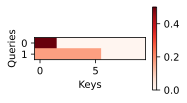

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape(1, 1, 2, 10), xlabel='Keys', ylabel='Queries')

### 缩放点积注意力(Scaled Dot-product Attention)

- 在实践中，例如每个批量有n个query和m个key，query和key的维度都是d，value的维度是v，查询$\mathbf{Q} \in \mathbb{R^{n \times d}}$， 键值$\mathbf{K} \in \mathbb{R^{m \times d}}$，值$\mathbf{V} \in \mathbb{R^{m \times v}}$的缩放点积注意力为：
$$\text{softmax}(\frac{\mathbf{QK^T}}{\sqrt{d}})\mathbf{V} \in \mathbb{R^{n \times v}}$$


In [9]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        """
        queries [bs, n_q, d]
        keys [bs, n_kv, d]
        values [bs, n_kv, d]
        valid_lens [bs, ] or [bs, n_q] 有效序列的长度
        """
        d = queries.shape[-1]
        # [bs, n_q, n_kv]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [10]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(0.1)
attention.eval()
attention(queries, keys, values, valid_lens), attention.attention_weights.shape

(tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],
 
         [[10.0000, 11.0000, 12.0000, 13.0000]]]),
 torch.Size([2, 1, 10]))

- 与加性注意力演示相同，由于键包含的是相同的元素， 而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。

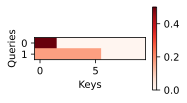

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape(1, 1, 2, 10), 
                  xlabel='Keys', ylabel='Queries')